In [1]:
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
import pandas as pd
import networkx as nx

import matplotlib as mpl

mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

from typing import List
from collections import Counter

ModuleNotFoundError: No module named 'networkx'

# The SIR model

We will focus on the SIR model, probably the most studied model in computational epidemics. In its simplest form, the SIR model can be defined as follows. A large population of $N$ individuals is divided into three classes:
+ **Susceptible** individuals (S): those who do not have the disease but can get it.
+ **Infected** individuals (I) : those who have the disease.
+ **Recovered** individuals (R): those who cannot get the disease anymore.

The basic dynamics of the model are simple as well:
1. Susceptible individuals might get infected if they are in contact with an infected individual. 
2. Infected individuals become recovered after some time. 

Notice that individuals can only go from *S* to *I* and from *I* to *R*. We will also assume that infective individuals have contacts with randomly chosen individuals of all states at an average rate $\beta$ per unit time, and recover and acquire immunity (or die) at an average rate $\gamma$ per unit time. 


### Fully mixed population
If we assume a very large population that is **fully mixed**, then the model can be descrived by a set of coupled nonlinear differential equations:  


<img src="attachment:image.png" width="400"> 

### Exercise 5.1
The `scipy.integrate` library has a function `solve_ip` that can be used to solve initial value problems for systems of ODES.
The documentation can be found [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html).

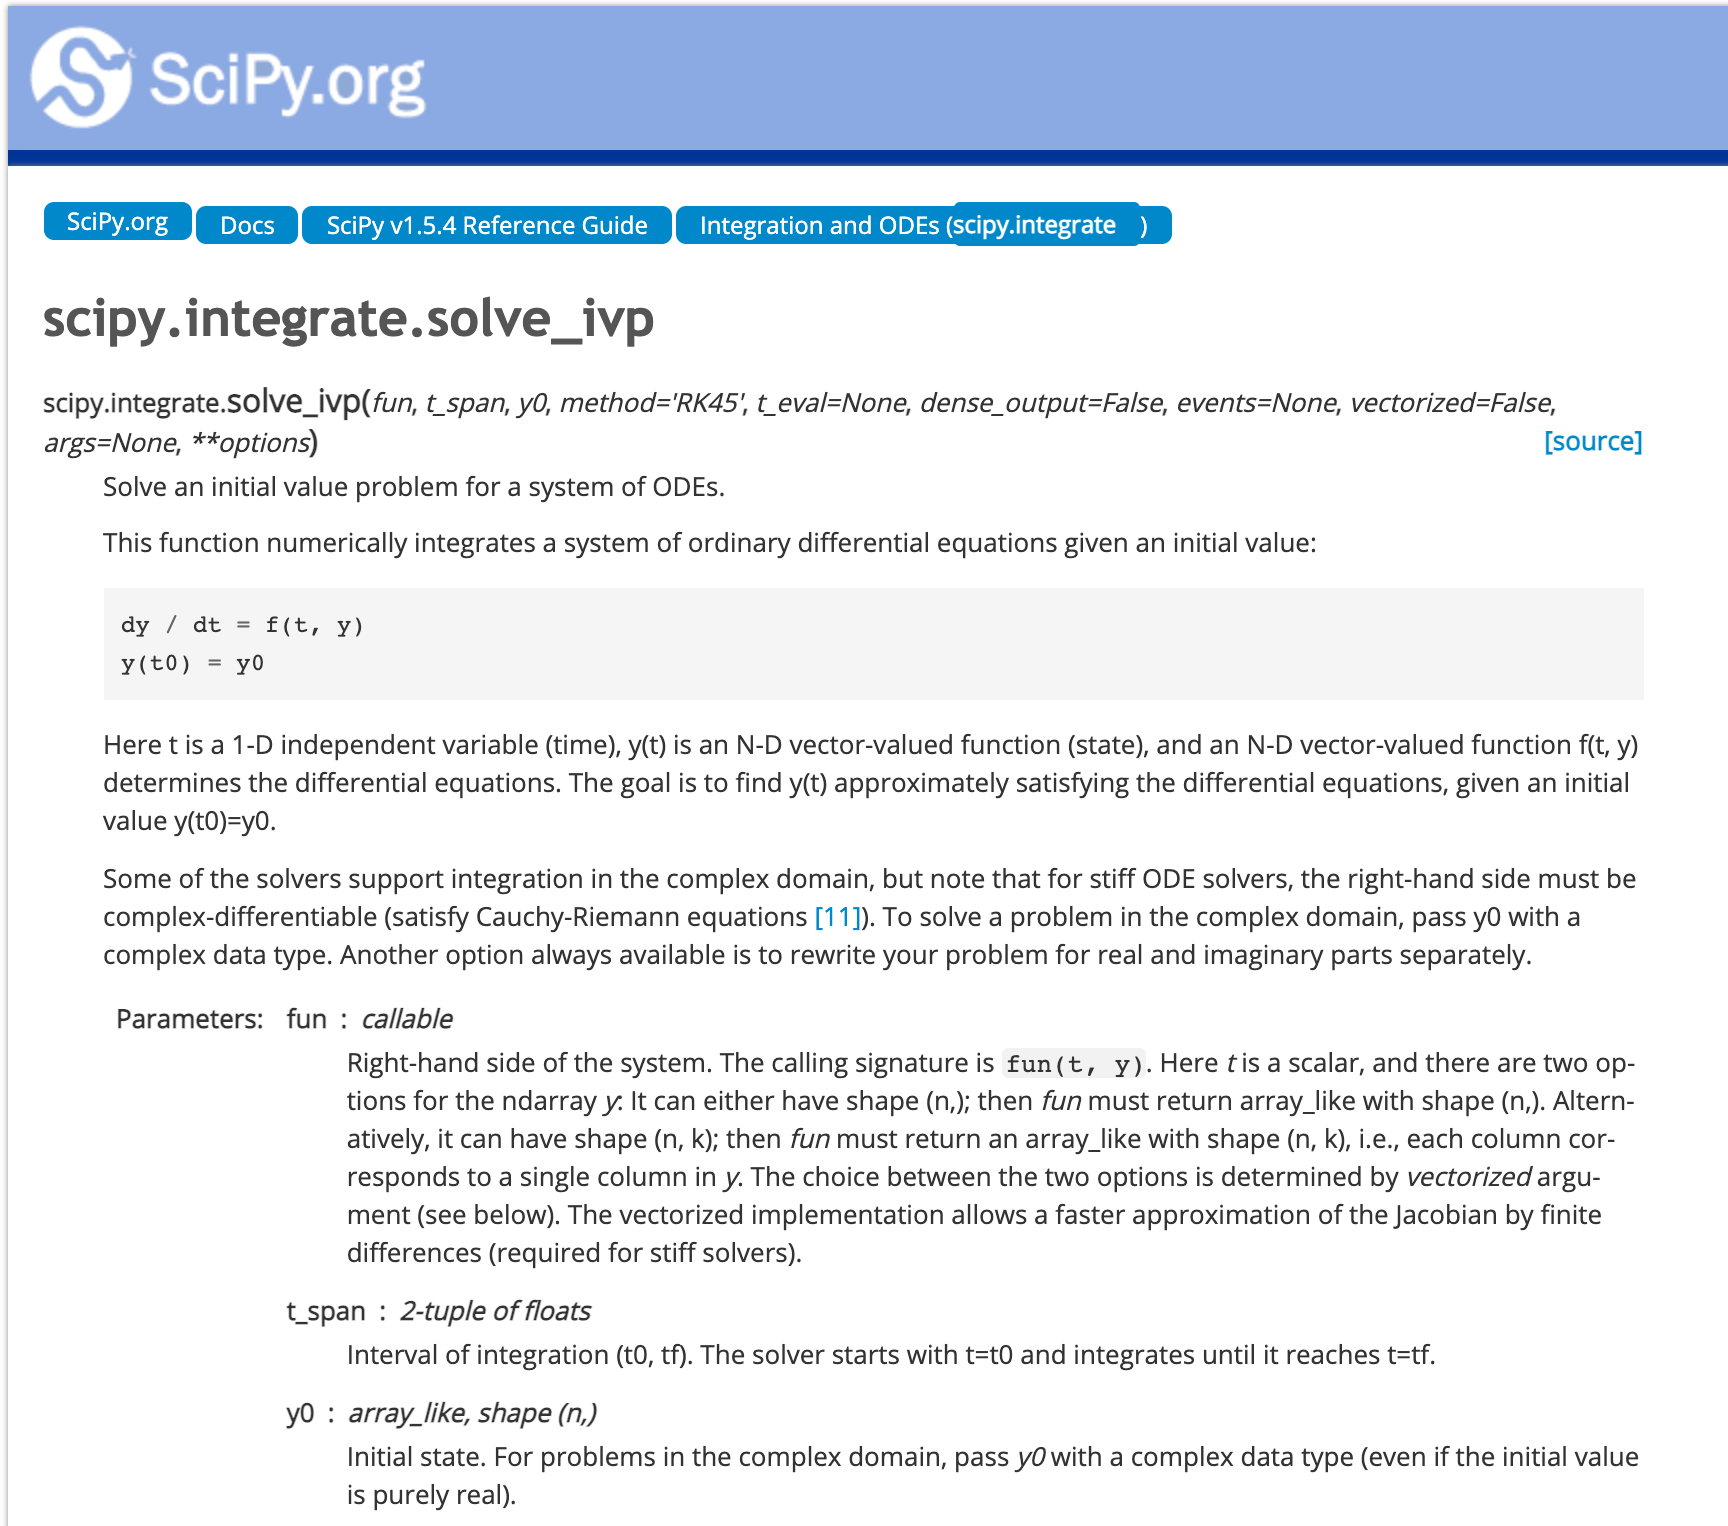


Read the documentation and try to understand how to use `solve_ivp`. The key bit is to notice that we have to write a **function** `f(t, y)`  whose first argument is the timepoint `t` and whose second argument `y` is a numpy array. In our case, y will have dimension 3. Do you see why?


The Initial Value Problem to be solved is then simply

```text
    dy / dt = f(t, y)
    y(t0) = y0
```


Write a function `ode_SIR` that represents the system of differential equations of a SIR model and follows the specification of `solve_ivp`.

In [ ]:
def odes_SIR(t, y):
    """
    The main ODE equations of the SIR model
    """
    S, I, R = y[0], y[1], y[2]
    N = S + I + R
    f=np.array([
        - beta * S * I/N ,
        beta * S * I/N - gamma * I,
        gamma * I,        
    ])
    return f


### Exercise 5.2
Use `solve_ivp` and your `ode_SIR` function to study the behaviour of the SIR model for different values of the parameters, and describe your findings with a short paragraph.

In [ ]:
# set parameters
beta=0.01
gamma=0.003
y0 = (497, 3, 0)
tmax = 3000

In [ ]:
# solve ODE
ode_result = sp.integrate.solve_ivp(odes_SIR, (0, tmax), y0)

In [ ]:
# extract results
assert ode_result.success
t_range = ode_result.t
S, I, R = ode_result.y

Text(0.5, 1.0, 'Epidemic Evolution')

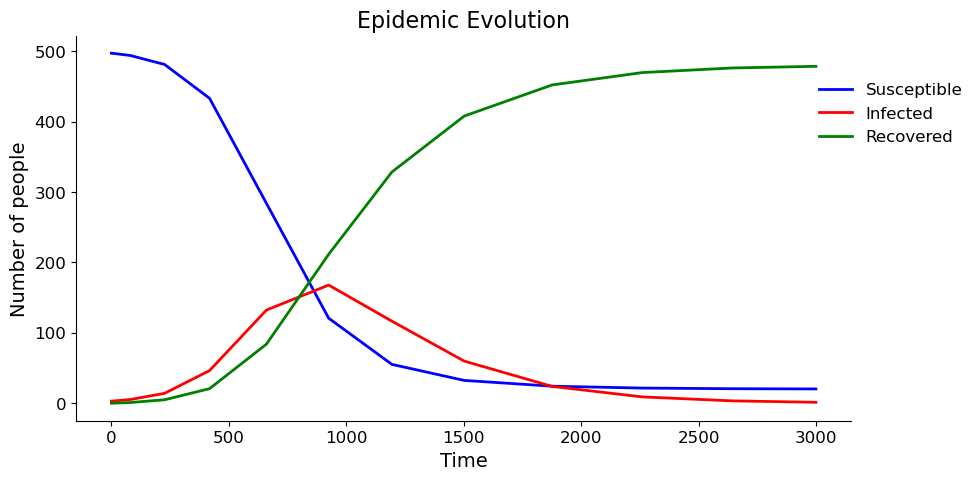

In [ ]:
# OPTIONAL to get the same colors for S, I, R plots over all the notebook, we can define a dictionary of colors
SIR_colors = {
    "S": "#8aceff",
    "I": "#e35dbf",
    "R": "#ace08b"
}

# plot solution (S, I, R) on y axis, time on x-axis
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.plot( 
    t_range, S,
    color = "blue",
    lw = 2,
    label="Susceptible"
)

ax.plot( 
    t_range, I,
    color = "red",
    lw = 2,
    label="Infected"
)

ax.plot( 
    t_range, R,
    color =  "green",
    lw = 2,
    label = "Recovered"
)

# add axis labels
ax.set_xlabel(r"Time")
ax.set_ylabel(r"Number of people")
# add a legend
ax.legend(loc=(0.95, 0.7), frameon=False)


# add a title (e.g. that says what dimension we used)
ax.set_title(f"Epidemic Evolution")

La simulazione inizia con 497 soggetti suscettibili e tre soggetti malati. Come si può notare nella parte iniziale della simulazione (fino a circa 300 unità di tempo) la crescita dei soggetti infetti è lenta in quanto si parte da pochi contagiati. Il picco di infetti lo si ha a circa 1000 unità di tempo (in quell'istante si hanno circa 150 persone malate contemporaneamente). Contestualmente si nota anche un aumento repentino dei guariti (che non possono poi reinfettarsi) che fa sì che la "potenza infettante" della malattia diminuisca. Si giunge infatti ad un rallentamento dell'infezione che può portare anche ad una sorta di "immunità di gregge" in cui non tutti i suscettibili contraggono la malattia.

### SIR model on a network
The ODE approximation of the SIR model is not very realistic because it assumes a fully mixed population.
The fact that we do not interact randomly with one another, but rather have complex social structures, schools, commuting etc is what makes the whole thing much more difficult.

To explorer the importance of the **contact network** for the spread of a disease, we will implement a simple discrete-time SIR model that runs on an arbitrary network or graph. To do so, we will define a class `SIRonGraph` that holds together the **graph** where the SIR model runs and the **methods** (aka functions) that implement the SIR dynamics.

We will use the `networkx` module, a well-known python library to work with networks data. To check if you have it installed in your computer, run

In [ ]:
import networkx as nx

If you get a `ModuleNotFoundError`, that means that you need to install it before continuing. In most cases, simply opening a terminal and running

```bash
> pip install networkx
```

should work. Additional installation instructions can be found [here](https://networkx.org/documentation/stable/install.html).

Networkx provides you the `Graph` type, that is, a kind of variable that represents a graph or network. Let us try it:

In [ ]:
G = nx.Graph()

Networks have nodes and edges. Let us add some. Here we use letters to label the nodes, but integers would work as well.

In [ ]:
G.add_nodes_from(["A", "B", "C", "D"])

In [ ]:
G.add_edges_from([("A", "B"), ("B", "C"), ("C", "A"), ("C", "D")])

Now we want to have a look at our network. Networkx gives us some handy functions!

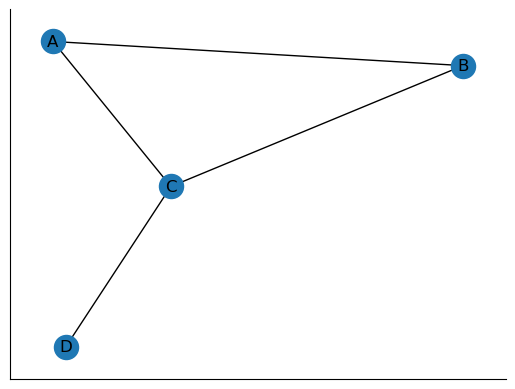

In [ ]:
nx.draw_networkx(G)

Finally, networks can also hold some data on their nodes on edges. These are called **attributes** and are very useful. Let us create one:

In [ ]:
initial_status = {
    "A": "S",
    "B": "S",
    "C": "I",
    "D": "S"
}

In [ ]:
nx.set_node_attributes(G, initial_status, name="kind")

Now G carries the attribute *kind* with it. We can get the values of attributes of individual nodes easily:

In [ ]:
G.nodes["C"]["kind"]

'I'

We can also modify the value of an attribute. Let us suppose node C infects node B. The we could do:

In [ ]:
G.nodes["B"]["kind"] = "I"

If we need to get the attribute of all nodes, we can do it at once as follows:

In [ ]:
current_status = nx.get_node_attributes(G, "kind")

In [ ]:
current_status

{'A': 'S', 'B': 'I', 'C': 'I', 'D': 'S'}

### The SIR model as a python class

We will now create a class `SIRonGraph` to represent a SIR model on an arbitrary network. A class holds together data and functions (callled methods), and is exactly what we need in this case: a network and some functions that implement the SIR dynamics on it.

Classes can be a bit confusing at the beginning, but all you need to understand is that `self` means literary 'myself', that is, methods (functions) get as first argument the object they are acting on. This means that we can "store" a variable in one method and "retrieve" it in another! No need to pass it around!

Look at the following example code and play with it to make sure you understand how `self` works.

In [ ]:
class Model:
    # this is a special method that gets called when you create an instance of your class
    def __init__(self, name):
        self.name = name
    
    def set_x(self, x):
        self.x = x
        
    def increment_x(self):
        self.x += 1

    def show_x(self):
        return self.x
    

In [ ]:
model1 = Model(name = "my first model")
model2 = Model(name = "another model")

In [ ]:
model1.set_x(3)
model2.set_x(-2)

In [ ]:
model1.increment_x()

In [ ]:
model1.show_x()

4

In [ ]:
model2.show_x()

-2

We can also access information stored in our objects. Notice that our models had a name that was set at initialization.

In [ ]:
model1.name

'my first model'

So, let us go back to our SIR model. The input to create a new SIR model on an arbitrary network is the following:

1. The graph onto which we want to run the SIR model.
2. A list of initially infected nodes.
3. The coefficient $\beta$
4. The coefficient $\gamma$

So, we create a class `SIRonGraph` that, when initialized, simply stores the input.

In [ ]:
class SIRonGraph:
    def __init__(self, network: nx.Graph, initial_infected: List[int], beta: float, gamma: float) -> None:
        """
        Initialize a SIR model on a network. 
        """
        # store parameters
        self.beta = beta
        self.gamma = gamma
        self.network = network

Let us try it. First we need to create a graph! Networkx has some functions to generate standard graphs. We could start with a lattice graph, for instance.

In [ ]:
# 2 rows, 3 columns
G = nx.hexagonal_lattice_graph(2, 3)

Notice that nodes are labelled with a tuple of integers `(col, row)` and that `G` comes with a nice `pos` node attribute, which we can use to nicely plot the network.

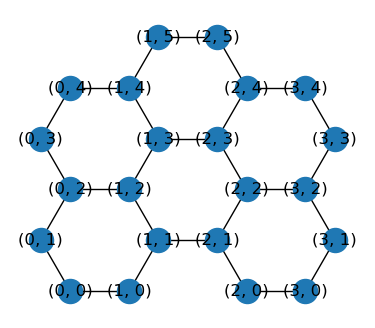

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.set_aspect(1)
ax.set_axis_off()

pos = nx.get_node_attributes(G, 'pos')
nx.draw_networkx(G, pos=pos)

Now we can create our first model

In [ ]:
model = SIRonGraph(network=G, beta=0.3, gamma=0.1, initial_infected=[(1, 3)])

Notice that you can retrieve all the information that is stored in `self`. 

In [ ]:
model.network

Notice that `model.network` is not a copy of `G`: it is exactly the same object, point to the same memory address!

In [ ]:
G

In [ ]:
model.beta

0.3

In [ ]:
model.gamma

0.1

### Exercise 5.3
Our model should do a few more things at initialization:
1. Checking that $\beta$ and $\gamma$ have sensible values.
2. Making sure that all elements in input list of inital infected are really nodes of the network.
2. Creating a node attribute called "kind" with value "S" for all nodes except for those in the list of `inital_infected`

Extend the SIRonGraph code below and implement points 1 and 2 in the ``__init__`` method.

In [ ]:
#In primo luogo capisco come fare un controllo per appartenenza graph
a = [(1, 2), (3, 4), (5, 6)]

G = nx.Graph()
G.add_nodes_from([(1,2), (2, 3), (5,6)])

if G.has_node(a[2]):
    print("ciao")

ciao


In [ ]:
#Capisco ora come dare attributi agli elementi
#Setto tutti gli stati inizialmente ad S
nx.set_node_attributes(G, 'S', name="kind")

for i in range (0, 3):
    if G.has_node(a[i]):
        w = {a[i] : 'I'}
        nx.set_node_attributes(G, w , name="kind")

current_status = nx.get_node_attributes(G, "kind")
current_status

{(1, 2): 'I', (2, 3): 'S', (5, 6): 'I'}

In [ ]:
class SIRonGraph:
    def __init__(self, network: nx.Graph, initial_infected: List[int], beta: float, gamma: float) -> None:
        """Initialize a SIR model on a network. 
        All nodes are set to S except those passed in the initial_infected list.
        """
        #Gli inizialmente infetti fanno effettivamente parte del network?? (me ne basta uno)
        N = len(initial_infected)
        conta = 0
        for i in range(0, N):
            if network.has_node(initial_infected[i]):
                conta += 1
        #Condizione di assert che controlla se ho i nodi oppure no
        assert conta != 0
        
        
        #Setto gli attributi  - inizialmente metto tutti ad S
        nx.set_node_attributes(network, 'S', name = "kind")
        
        #Controllo ora quali siano gli effettivamente infetti e cambio i loto attributi
        for i in range (0, N):
            if network.has_node(initial_infected[i]):
                w = {initial_infected[i] : 'I'}
                nx.set_node_attributes(G, w , name = "kind")

        #Vedo se i parametri hanno senso - non sono certissimo di questa scelta di condizioni
        assert beta <= 1 and beta > 0
        assert gamma <=1 and gamma > 0
        
        # store parameters
        self.network = network
        self.beta = beta
        self.gamma = gamma
    

### Exercise 5.4
1. Create a function to visualize a hexagonal lattice model, with nodes colored by type. Your function should take as input the model instance (object of kind SIRonGraph) and display the network, coloring S, I and R nodes with different colors.
2. Show that your function works for a few examples with different input graph sizes and different sets of initially infected nodes.

**Tip**: look into the networkx documentation! It is [here](https://networkx.org/documentation/stable/reference/drawing.html).

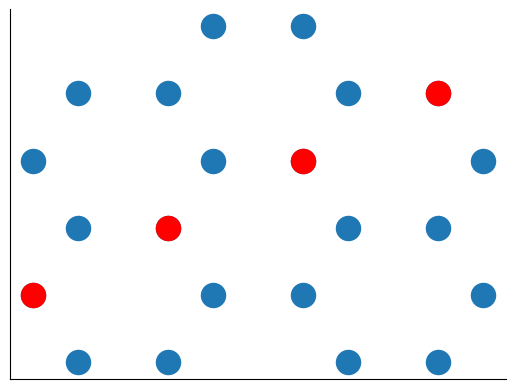

In [ ]:
#Nodi inizialmente infetti
a = [(1, 2), (3, 4), (0, 1), (2,3)]

#Creo con il metodo del punto precedente un sistema
G = nx.hexagonal_lattice_graph(2, 3)
prova = SIRonGraph(network = G, initial_infected = a, beta = 0.1, gamma = 0.05)

#***************************************#
#Capisco come disegnare solo alcuni nodi#
#***************************************#

#Determino gli attributi posizione
pos = nx.get_node_attributes(prova.network, 'pos')
#Determino gli attributi tipo
kinds = nx.get_node_attributes(prova.network, 'kind')

#disegno la totalità dei nodi (tutti in colore predefinito)
nx.draw_networkx_nodes(G, pos = pos)

nodi = G.nodes()
N = len(nodi)

nx.draw_networkx_nodes(G, pos = pos, nodelist = a, node_color = 'red')

#Il problema sta nel fatto che io non ho delle liste che contengono gli attualmente infetti ed i recovered
#Devo capire come posso fare in un caso del genere

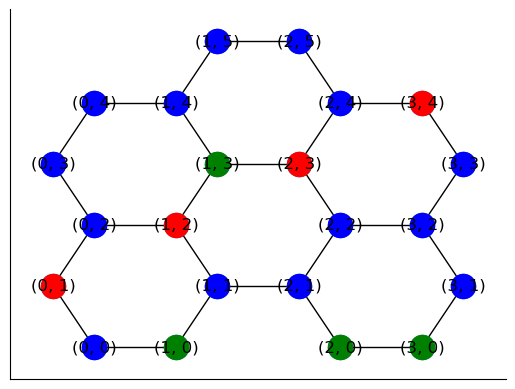

In [ ]:
#*************************************************#
#           Non ho lista, ma solo grafo           #
#*************************************************#

#Nodi inizialmente infetti
a = [(1, 2), (3, 4), (0, 1), (2,3)]

#Creo con il metodo del punto precedente un sistema
G = nx.hexagonal_lattice_graph(2, 3)
prova = SIRonGraph(network = G, initial_infected = a, beta = 0.1, gamma = 0.05)

#Setto alcuni nodi a R come tipo
w = {(1, 0) : 'R', 
     (1, 3) : 'R', 
     (2, 0) : 'R', 
     (3, 0) : 'R'}
nx.set_node_attributes(G, w , name = "kind")


#Setto i colori che voglio usare per le tre tipologie differenti di nodes
colore = {
    'R' : 'green',
    'S' : 'blue',
    'I' : 'red',
}

#Salvo le posizioni e le tipologie di nodi
pos = nx.get_node_attributes(G, 'pos')
kinds = nx.get_node_attributes(G, 'kind')

nx.draw_networkx(G, pos=pos)

for i in G.nodes():
    nx.draw_networkx_nodes(G, pos = pos, nodelist = [i], node_color = colore[kinds[(i)]])

In [ ]:
def show_hex_model(model, ax=None):
    
    # creates a figure if no axis was passed
    #così sono sicuro in qualsiasi caso di avere output grafico
    ax_was_none = ax is None
    if ax_was_none:
        # create a figure
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
        ax.set_aspect(1)
        ax.set_axis_off()
        
        
    # get the positions and kind of nodes
    pos = nx.get_node_attributes(model.network, 'pos')
    kinds = nx.get_node_attributes(model.network, 'kind')

    # prepare a list of colors for the nodes using the kinds dict
    colore = {
    'R' : 'green',
    'S' : 'blue',
    'I' : 'red',
    }
    
    #disegno gli edges
    nx.draw_networkx_edges(model.network, pos=pos)

    # draw the network
    for i in model.network.nodes():
        nx.draw_networkx_nodes(model.network, pos = pos, nodelist = [i], node_color = colore[kinds[(i)]])
    
    # returns the new figure if it was created here
    if ax_was_none:
        return fig, ax

### SIR dynamics as class methods
Now we want to be able to run the SIR dynamics on our `SIRonGraph` objects. To simplify things, we  consider **discrete time** simulation, so that at each time-step:
+ Infected individuals have a chance to recover, and they do so with probability $\gamma$.
+ Susceptible individuals can be infected by any of the infected individuals to which they are connected. This happens with probability $\beta$ for each S-I edge.

### Exercise 5.5
Implement the dynamics of the SIR model as methods of your `SIRonGraph` class. You might want to implement two methods separately, as follows:

+ `_step(self)`: this method implements one single time-step, as descrived above.
+ `run(self, num_timesteps: int)`: this method (for now) simply calls `_step` repeatedly.

You will see, in a while, that it is useful to organize things as we are doing.

In [ ]:
#****************************************#
#    Capisco come lavorare con edges     #
#****************************************#

#Creo un modello da utilizzare per i test
#Nodi inizialmente infetti
a = [(1, 2), (3, 4), (0, 1), (2,3)]

#Creo con il metodo del punto precedente un sistema
G = nx.hexagonal_lattice_graph(2, 3)
prova = SIRonGraph(network = G, initial_infected = a, beta = 0.1, gamma = 0.05)

#Setto alcuni nodi a R come tipo
w = {(1, 0) : 'R', 
     (1, 3) : 'R', 
     (2, 0) : 'R', 
     (3, 0) : 'R'}
nx.set_node_attributes(G, w , name = "kind")

edg = nx.edges(G)

for i in edg:
    #Questo comando mi consente di accedere al limite sinistro della connessione
    print(G.nodes[i[0]]['kind'])
    print(i)
    


S
((0, 0), (0, 1))
S
((0, 0), (1, 0))
I
((0, 1), (0, 2))
S
((0, 2), (0, 3))
S
((0, 2), (1, 2))
S
((0, 3), (0, 4))
S
((0, 4), (1, 4))
R
((1, 0), (1, 1))
S
((1, 1), (1, 2))
S
((1, 1), (2, 1))
I
((1, 2), (1, 3))
R
((1, 3), (1, 4))
R
((1, 3), (2, 3))
S
((1, 4), (1, 5))
S
((1, 5), (2, 5))
R
((2, 0), (2, 1))
R
((2, 0), (3, 0))
S
((2, 1), (2, 2))
S
((2, 2), (2, 3))
S
((2, 2), (3, 2))
I
((2, 3), (2, 4))
S
((2, 4), (2, 5))
S
((2, 4), (3, 4))
R
((3, 0), (3, 1))
S
((3, 1), (3, 2))
S
((3, 2), (3, 3))
S
((3, 3), (3, 4))


Il metodo step che viene implementato è costituito da 3 parti. Inizialmente si cicla sui vari edges del network creando una lista dei nodi che vengono contagiati, senza però aggiornarne l'attributo "kind". In un secondo momento si prendono nuovamente in considerazione gli infetti e li si fa guarire con una probabilità gamma. Infine si cambia l'attributo dei nodi contagiati da S in I. Così facendo si evita che gli infetti guariscano istantaneamente (situazione che non si può verificare nela realtà).

In [ ]:
class SIRonGraph:
    def __init__(self, network: nx.Graph, initial_infected: List[int], beta: float, gamma: float) -> None:
        """Initialize a SIR model on a network. 
        All nodes are set to S except those passed in the initial_infected list.
        """
        #Gli inizialmente infetti fanno effettivamente parte del network?? - me ne basta uno
        N = len(initial_infected)
        conta = 0
        for i in range(0, N):
            if network.has_node(initial_infected[i]):
                conta += 1
        #Condizione di assert che controlla se ho i nodi oppure no
        assert conta != 0
        
        
        #Setto gli attributi  - inizialmente metto tutti ad S
        nx.set_node_attributes(network, 'S', name="kind")
        
        #Controllo ora quali siano gli effettivamente infetti e cambio i loto attributi
        for i in range (0, N):
            if network.has_node(initial_infected[i]):
                w = {initial_infected[i] : 'I'}
                nx.set_node_attributes(G, w , name="kind")

        #Vedo se i parametri hanno senso - non sono certissimo di questa scelta di condizioni
        assert beta <= 1 and beta > 0
        assert gamma <=1 and gamma > 0
        
        # store parameters
        self.network = network
        self.beta = beta
        self.gamma = gamma
    
    
    
    def _step(self):
        """Do one discrete timestep."""
        
        #Contenitore per i nodi infettati
        nodi_infettati = []
        
        #Ciclo sugli infetti e memorizzo i suscettibili che vengono infettati in questo step (senza aggiornare il loro attributo)
        for edge in self.network.edges:
            #Nodo di sinistra infetto e nodo di destra sano
            if self.network.nodes[edge[0]]['kind'] == 'I' and self.network.nodes[edge[1]]['kind'] == 'S':
                #Genero un numero random fra zero ed uno per avere la probabilità di passaggio
                appo = np.random.random()
                if appo <= self.beta:
                    nodi_infettati.append(edge[1])
            
            elif self.network.nodes[edge[0]]['kind'] == 'S' and self.network.nodes[edge[1]]['kind'] == 'I':
                #Genero un numero random fra zero ed uno per avere la probabilità di passaggio
                appo = np.random.random()
                if appo <= self.beta:
                    nodi_infettati.append(edge[0])
        
        #Ciclo nuovamente sugli infetti e li faccio guarire con probabilità gamma
        for node in self.network.nodes:
            if self.network.nodes[node]["kind"] == "I":
                #Creo una variabile random fra 0 e 1 che mi descrive se ho guarigione oppure no
                appo = np.random.random()
                
                #Casistica di cambio da malato a guarito
                if appo <= self.gamma:
                    self.network.nodes[node]["kind"] = "R"
                    
        
        #Ciclo sui nodi infettati con la prima parte di codice per cambiarne l'attributo
        for i in nodi_infettati:
            self.network.nodes[i]['kind'] = 'I'
    
    
    def run(self, num_timesteps: int):
        """Run SIR dynamics for num_timsteps steps"""
        for i in range(0, num_timesteps):
            SIRonGraph._step(self)
                

### Exercise 5.6
Use your visualization function to show the evolution of a SIR model running in a hex lattice. You should decide the system size, number of timesteps and other parameterrs wisely to show that your code works properly.

In [ ]:
G = nx.hexagonal_lattice_graph(10, 10)
model = SIRonGraph(network=G, initial_infected=[(5, 5), (2,3)], beta=0.15, gamma=0.04)

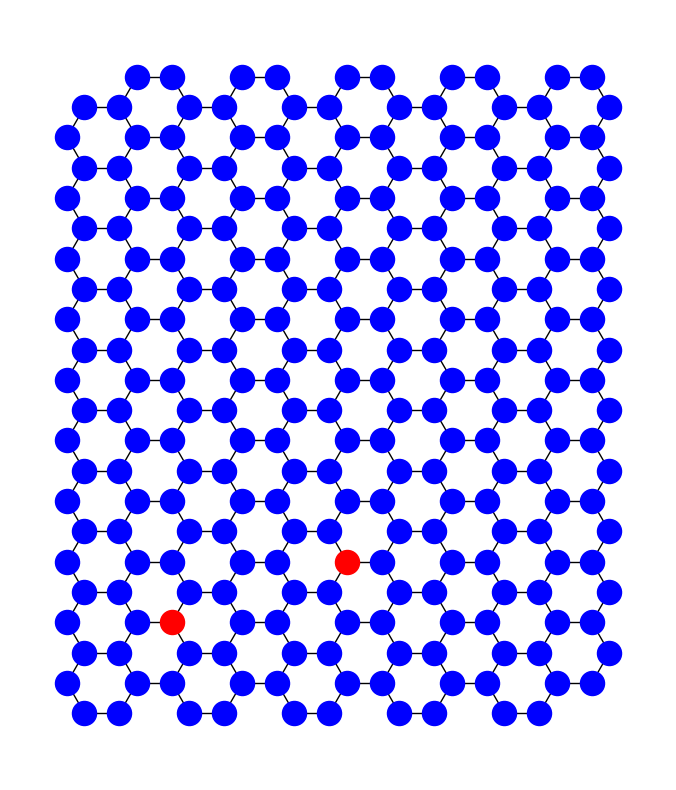

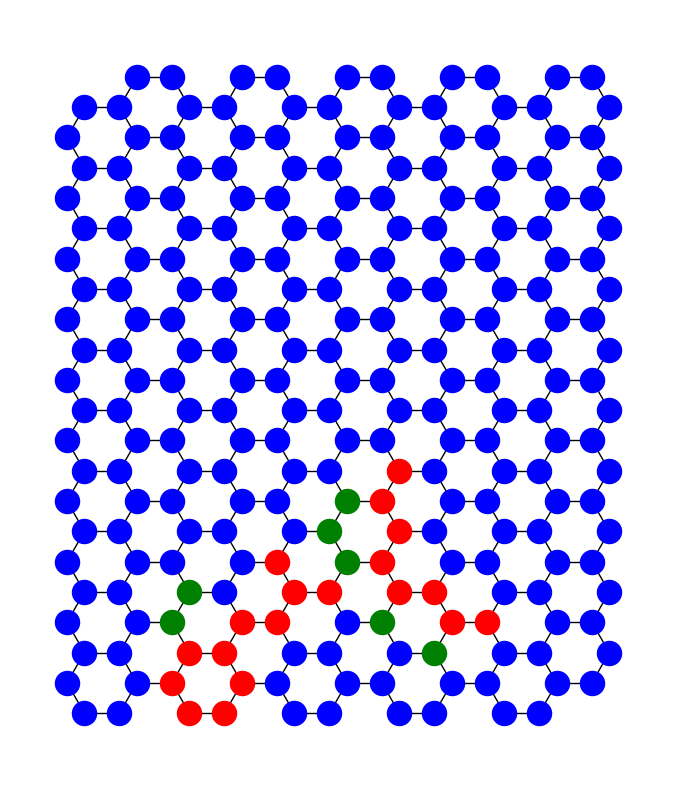

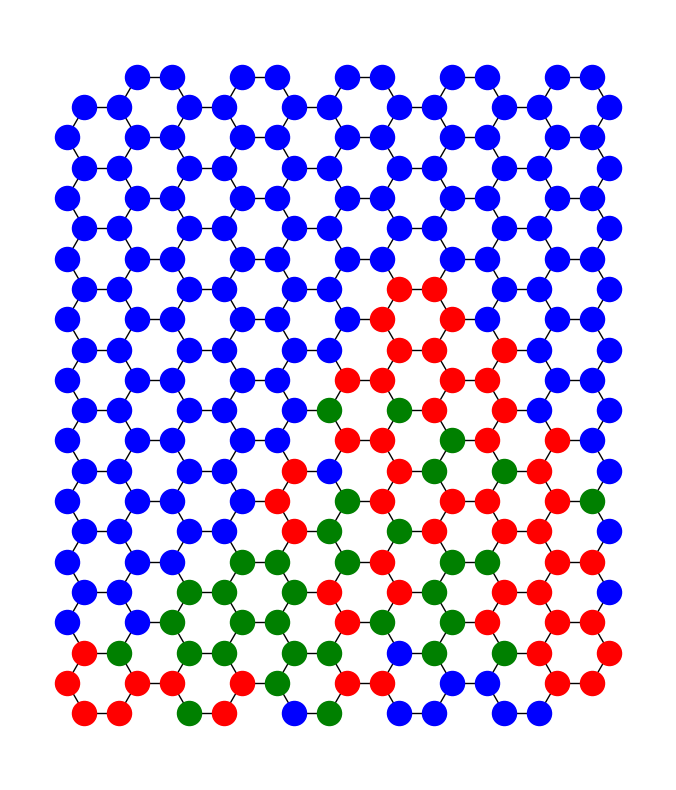

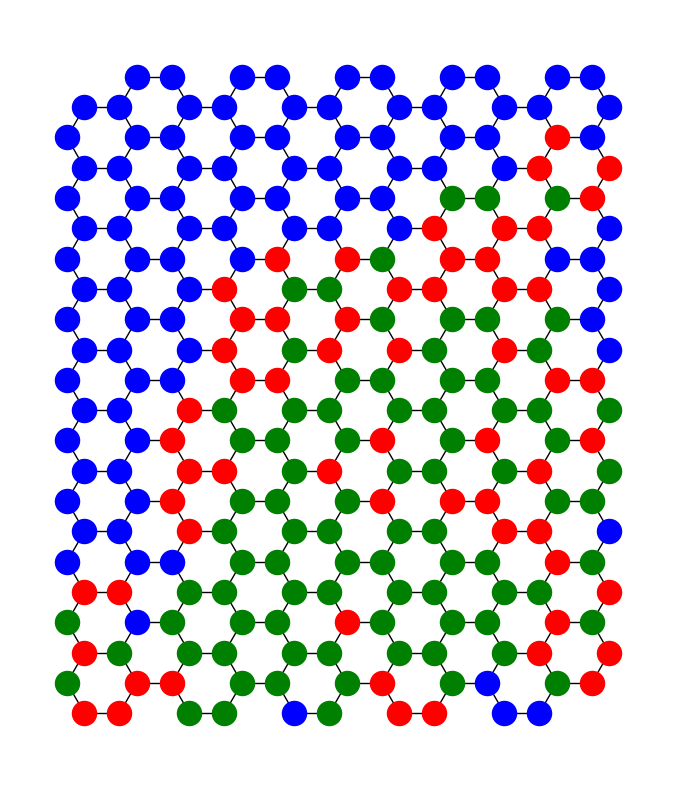

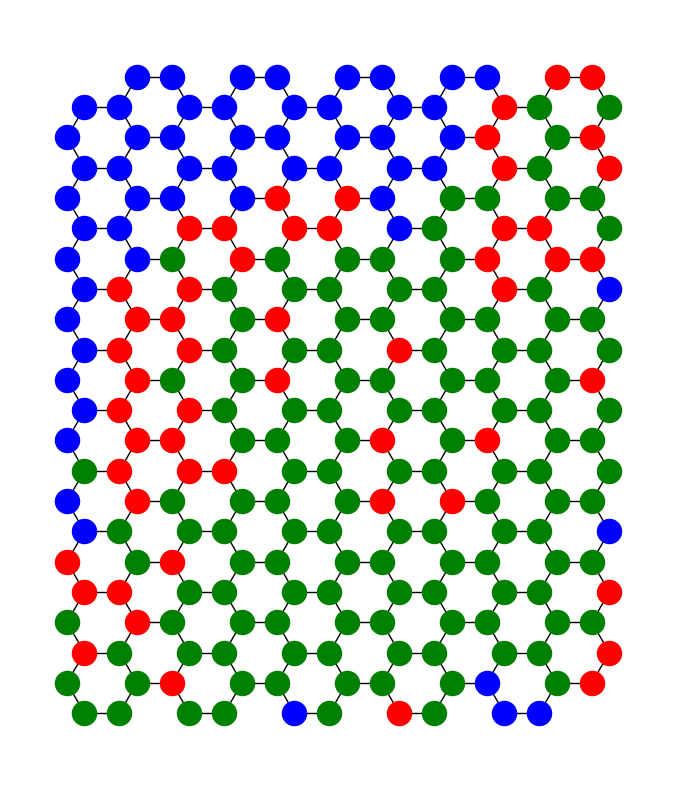

In [ ]:
for i in range(0,5):
    ### plot model status on axis ax
    show_hex_model(model)
    
    ### run the model for some timesteps
    model.run(num_timesteps = 20)
    


### Storing SIR evolution as a class attribute
Now our class can run the SIR dynamics, but it doesn't "remember" the whole evolution of the simulation: only the final state is available. One way of storing some quantities of interest during the simulation is as follows:

1. Create an empty list at initialization.
```python
class SIRonGraph:
     def __init__(self, G: nx.Graph, initial_infected: List[int], beta: float, gamma: float) -> None:
         ...
         # empty list, we will add info durring the simulation
         self.history = []
         ...
```

2. Create a _log() method that, when called, computes the information we want to store and adds it to the self.history list.

```python
   def _log(self):
        # do computations
        var1 = ...
        var2 = ...
        ...
        
        # create a block of info as list
        info = [var1, var2, ...]
        # or as a dict
        info = {
            "var1": var1,
            "var2": var2,
            ...
        }
        # or using any other scheme you like
        info = ...
        
        # add the info block to the history log
        self.history.append(info)
```

3. Call the ._log() method every time you want to store the variables of interest. That could be at every timestep or once in a while only. 
It is also wise to call `._log()` once at initialization, to store the initial status. 
```python
   def __init__(self, ...):
         ...
         self._log()
        
   def run(self, num_timesteps: int):
         """Run the SIR dynamics for some time."""
         ...
         for _ in range(num_timesteps):
              self._step()
              self._log()
         ...
```

### Exercise 5.7
1. Modify your SIRonGraph class so that it stores the number of **S**, **I** and **R** individuals at each timestep.
2. Simulate the SIR model in a network of your choice, and plot the evolution of the system (S, I, R) over time. Try to choose the parameters wisely, so that a typical epidemic wave can be seen.

In [ ]:
class SIRonGraph:
    def __init__(self, network: nx.Graph, initial_infected: List[int], beta: float, gamma: float) -> None:
        """Initialize a SIR model on a network. 
        All nodes are set to S except those passed in the initial_infected list.
        """
        #Gli inizialmente infetti fanno effettivamente parte del network?? - me ne basta uno
        N = len(initial_infected)
        conta = 0
        for i in range(0, N):
            if network.has_node(initial_infected[i]):
                conta += 1
        #Condizione di assert che controlla se ho i nodi oppure no
        assert conta != 0
        
        
        #Setto gli attributi  - inizialmente metto tutti ad S
        nx.set_node_attributes(network, 'S', name="kind")
        
        #Controllo ora quali siano gli effettivamente infetti e cambio i loto attributi
        for i in range (0, N):
            if network.has_node(initial_infected[i]):
                network.nodes[initial_infected[i]]["kind"] = 'I'

        #Vedo se i parametri hanno senso - non sono certissimo di questa scelta di condizioni
        assert beta <= 1 and beta > 0
        assert gamma <=1 and gamma > 0
        
        # store parameters
        self.network = network
        self.beta = beta
        self.gamma = gamma
        
        # create empty list to store history        
        self.history = []
        
        #Conto i numeri delle tre categorie presenti nel modello
        S, I, R = 0, 0, 0
        for i in self.network.nodes():
            #Caso di nodo suscettibile
            if self.network.nodes[i]['kind'] == 'S':
                S += 1
            #Caso nodo infettato
            elif self.network.nodes[i]['kind'] == 'I':
                I += 1
            #Caso nodo 'recovered'
            elif self.network.nodes[i]['kind'] == 'R':
                R += 1
        
        #Variabile di appoggio per aggiungere dati appena calcolati
        pippo = [S, I, R]
        self.history.append(pippo)
        
        
    def run(self, num_timesteps: int):
         for i in range(0, num_timesteps):
            SIRonGraph._step(self)
            SIRonGraph._log(self)
            
        
        
    def _step(self):
        """Do one discrete timestep."""
        
        #Contenitore per i nodi infettati
        nodi_infettati = []
        
        #Ciclo sugli infetti e memorizzo i suscettibili che vengono infettati in questo step (senza aggiornare il loro attributo)
        for edge in self.network.edges:
            #Nodo di sinistra infetto e nodo di destra sano
            if self.network.nodes[edge[0]]['kind'] == 'I' and self.network.nodes[edge[1]]['kind'] == 'S':
                #Genero un numero random fra zero ed uno per avere la probabilità di passaggio
                appo = np.random.random()
                if appo <= self.beta:
                    nodi_infettati.append(edge[1])
            
            elif self.network.nodes[edge[0]]['kind'] == 'S' and self.network.nodes[edge[1]]['kind'] == 'I':
                #Genero un numero random fra zero ed uno per avere la probabilità di passaggio
                appo = np.random.random()
                if appo <= self.beta:
                    nodi_infettati.append(edge[0])
        
        #Ciclo nuovamente sugli infetti e li faccio guarire con probabilità gamma
        for node in self.network.nodes:
            if self.network.nodes[node]["kind"] == "I":
                #Creo una variabile random fra 0 e 1 che mi descrive se ho guarigione oppure no
                appo = np.random.random()
                
                #Casistica di cambio da malato a guarito
                if appo <= self.gamma:
                    self.network.nodes[node]["kind"] = "R"
                    
        
        #Ciclo sui nodi infettati con la prima parte di codice per cambiarne l'attributo
        for i in nodi_infettati:
            self.network.nodes[i]['kind'] = 'I'
        
        
        
    def _log(self):
        #Conto i numeri delle tre categorie presenti nel modello
        S, I, R = 0, 0, 0
        
        #Valuto quanti S,I,R
        for i in self.network.nodes():
            #Caso di nodo suscettibile
            if self.network.nodes[i]['kind'] == 'S':
                S += 1
            #Caso nodo infettato
            elif self.network.nodes[i]['kind'] == 'I':
                I += 1
            #Caso nodo 'recovered'
            elif self.network.nodes[i]['kind'] == 'R':
                R += 1
        
        
        info = [S, I, R]
        self.history.append(info)
                

In [ ]:
# create the model
model = SIRonGraph(
    network=nx.hexagonal_lattice_graph(30, 20),
    initial_infected=[(10, 10), (2, 2), (2, 5)],
    beta=0.06,
    gamma=0.01
)



In [ ]:
# run the model for some time
model.run(num_timesteps = 1200)

In [ ]:
# extract evolution of S, I, R from model.history
contenitore = model.history

Text(0.5, 1.0, 'Andamento infezione')

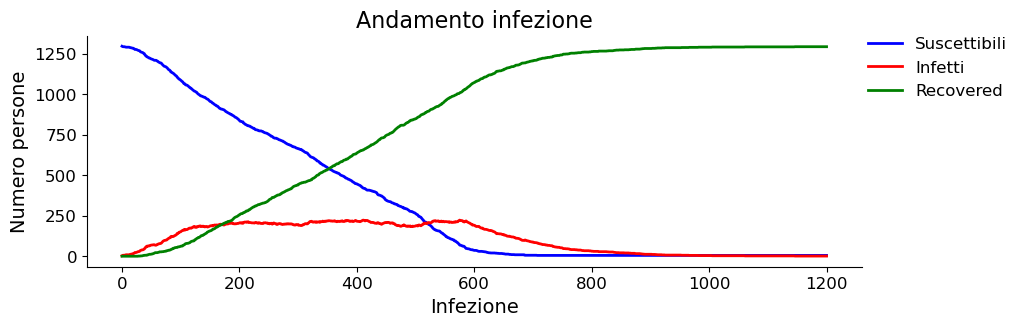

In [ ]:
# plot S,I,R vs time
fig, ax = plt.subplots(1, 1, figsize=(10,3))

#Dimensione del vettore contenitore
N = len(contenitore)

#Creo il vettore per il tempo
tempo = [i
        for i in range(0, N)]
#Creo le liste per plottare le tre differenti quantità
Susceptible = []
Infected = []
Recovered = []

#Divido le tre informazioni che ho salvato
for i in contenitore:
    Susceptible.append(i[0])
    Infected.append(i[1])
    Recovered.append(i[2])

#Plotto l'andamento dei suscettibili    
ax.plot(
    tempo, Susceptible,
    # style keywords
    color = "blue", lw = 2, 
    label = "Suscettibili"
)
#Plotto l'andamento degli infetti
ax.plot(
    tempo, Infected,
    # style keywords
    color = "red", lw = 2,
    label = "Infetti"
)
#Plotto l'andamento dei recovered
ax.plot(
    tempo, Recovered,
    # style keywords
    color = "green", lw = 2,
    label = "Recovered"
)

ax.legend(loc=(1, 0.7), frameon=False)

ax.set_ylabel(r"Numero persone")
ax.set_xlabel(r"Infezione")
ax.set_title(f"Andamento infezione")



### Exercise 5.8
Which kind of network could give results equivalent to the ODE solution of the first part of the notebook? Explain why.

Un network che potrebbe restituire dei risultati equivalenti a quelli ottenuti come risoluzione delle equazioni differenziali nella prima parte del notebook è un grafo in cui tutti i nodi sono collegati con tutti. Con una strutura di questo genere ogni elemento facente parte del network può interagire con tutti gli altri costitenti in modo tale da dare una condizione di "fully mixed population". Bisogna tuttavia dividere beta per il numero di nodi, per riprodurre la situazione che si ha nel sistema di equazioni differenziali riportato inizialmente: si ha infatti che tutti i termini che presentano beta come fattore moltiplicativo sono proporzionali ad $1/N$, mentre gli altri no. Se non si dovesse prendere questo accorgimento si avrebbe una infezione in cui il network si satura subito di persone infette dato l'elevato numero di collegamenti fra nodi.

### Exercise 5.9
Compare the ODE solution with simulation results on the appropiate network. Do you see differences? If so, explain why.
Remember to properly add labels and legends to all your plots!

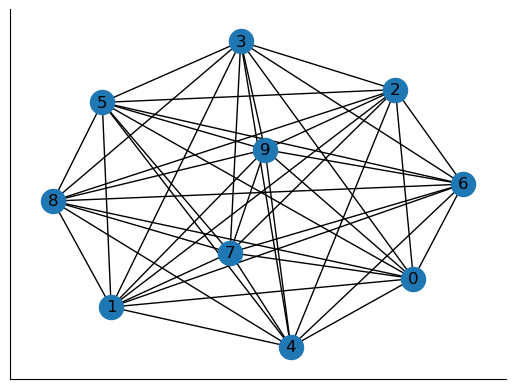

In [ ]:
#********************************************#
#       Imparo a usare complete graph        #
#********************************************#

G = nx.complete_graph(10)
nx.draw_networkx(G)

In [ ]:
# define your model
model = SIRonGraph(
    network=nx.complete_graph(500),
    beta=0.00002,
    gamma=0.003,
    initial_infected= [1, 5, 38]
)

In [ ]:
#Evolvo il modello ed estraggo i risultati
model.run(num_timesteps = 3000)
contenitore = model.history

Text(0.5, 1.0, 'Andamento infezione')

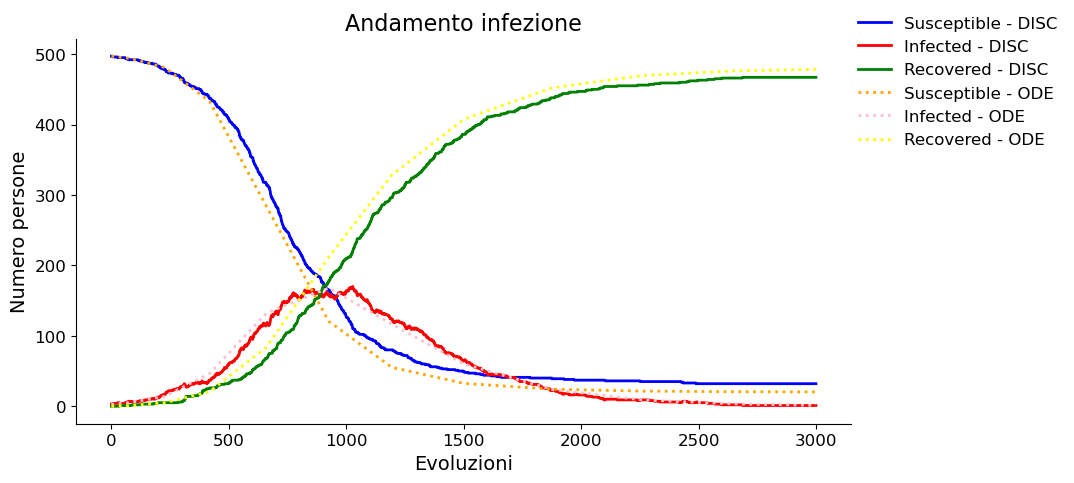

In [ ]:
#Plotto i risultati insieme a quelli della prima parte del notebook
fig, ax = plt.subplots(1, 1, figsize=(10,5))

#Dimensione del vettore contenitore
N = len(contenitore)

#Creo il vettore per il tempo
tempo = [i
        for i in range(0, N)]


#********************************#
#         Modello nuovo          #
#********************************#
#Creo le liste per plottare le tre differenti quantità
Susceptible = []
Infected = []
Recovered = []

#Divido le tre informazioni che ho salvato
for i in contenitore:
    Susceptible.append(i[0])
    Infected.append(i[1])
    Recovered.append(i[2])

#Plotto l'andamento dei suscettibili    
ax.plot(
    tempo, Susceptible,
    # style keywords
    color = "blue", lw = 2,
    label="Susceptible - DISC"
)
#Plotto l'andamento degli infetti
ax.plot(
    tempo, Infected,
    # style keywords
    color = "red", lw = 2,
    label = "Infected - DISC"
)
#Plotto l'andamento dei recovered
ax.plot(
    tempo, Recovered,
    # style keywords
    color = "green", lw = 2,
    label = "Recovered - DISC"
)


#********************************#
#        Modello vecchio         #
#********************************#
ax.plot( 
    t_range, S,
    color = "orange",
    lw = 2,
    label="Susceptible - ODE", 
    ls = ":"
)

ax.plot( 
    t_range, I,
    color = "pink",
    lw = 2,
    label="Infected - ODE",
    ls = ":"
)

ax.plot( 
    t_range, R,
    color =  "yellow",
    lw = 2,
    label = "Recovered - ODE", 
    ls = ":"
)

# add a legend
ax.legend(loc=(1, 0.7), frameon=False)




ax.set_ylabel(r"Numero persone")
ax.set_xlabel(r"Evoluzioni")
ax.set_title(f"Andamento infezione")

L'andamento dei due plot sovrapposti è confrontabile. In entrambi i casi il picco dell'infezione viene raggiunto dopo circa 1000 evoluzioni del sistema: da quell'istante di tempo in avanti il numero di infetti decresce fino a tornare a zero. Si notano tuttavia delle differenze fra le due simulazioni come, per esempio, il raggiungimento di "situazioni di equilibrio" (ossia oltre le 2500 evoluzioni) caratterizzate da un diverso numero di suscettibili e recovered, oppure da leggere fluttuazioni per quanto riguarda il numero di infetti. Queste differenze sono riconducibili al fatto che il modello plottato con linee continue è discreto. Si ha inoltre una probabilità non nulla, per come è stata implementata la singola evoluzione del sistema, che il plot riguardante il modello discreto presenti 3 linee orizzontali. In tale caso gli infetti di partenza sono guariti prima di infettare i loro vicini.

## The spread of epidemic disease on networks
We will now follow some of the derivations in 

*Spread of epidemic disease on networks.*  
Newman, M.E.J. (2002).  
Phys. Rev. E Stat. Nonlin. Soft Matter Phys. 66, 016128.  

You can get the preprint version of the paper, which is almost equal to the published verison, here:  
[https://arxiv.org/abs/cond-mat/0205009](https://arxiv.org/abs/cond-mat/0205009)  

Remember that the *transmissibility* $T$ is the average probability that a victim will infect each of their contacts.
In the paper, Newmann computes it as (Eq 6)
$$
T =  1 - \int_0^\infty dr \sum_{\tau=0}^{\infty} P(r) P(\tau) (1-r)^\tau
$$

### Exercise 5.10
Read the first part of the paper. Under which assumptions is the Eq. 6 valid? What is the meaning of $r$ and $\tau$ in the manuscript? Can you relate $P(r)$ and $P(\tau)$ to our coefficients $\beta$ and $\gamma$?

L'equazione (6) è valida sotto due assunzioni principali. La prima riguarda il fatto che deve essere utilizzato un network di connessioni fra i vari elementi che costituiscono il sistema sul quale stiamo studiando lo spread della malattia. In una situazione di questo genere la malattia si trasmette solo lungo i link del network: questo fa si che il modello che troveremo sia confrontabile con quanto accade nella realtà, dato che solitamente ogni individuo ha contatti ravvicinati e tali da consentire lo spread della malattia solamente con un gruppo limitato di persone. La seconda assunzione che deve essere fatta è che la probabilità di trasmissione della malattia sia diversa la link a link. Nella realtà si ha che sono presenti soggetti maggiormente a rischio di altri: questa situazione viene correttamente descritta e considerata dalla seconda delle due assunzioni. Nella relazione (6) sono presenti due parametri: $r$ e $\tau$. Il primo è la probabilità media per coppia di avere dei contatti tali da poter causare la malattia, mentre il secondo è il tempo per cui un individuo infetto rimane infetto e quindi in grado di contagiare altri individui. Una terza assunzione che facciamo per avere la validità dell'equazione (6) è che i parametri $r$ e $\tau$ siano due variabili casuali caratterizzate dall'avere due distribuzioni: $P(r)$ e $P(\tau)$. Tali distribuzioni possono essere legate a $\beta$, rate di contatti suscettibili - infetti che portano ad una sicura infezione, e a $\gamma$, rate di guarigione degli infetti, come segue: 
$$
P(r) = \delta(r - \beta)
$$
$$
P(\tau) = \delta_{\tau, 1/\gamma}
$$
Questo lo si ha perchè nel modello con cui stiamo lavorando il rate di contatti che danno luogo allo siluppo della malattia è sempre lo stesso (appunto $\beta$). Lo stesso vale per quanto riguarda il tempo di guarigione.

### Exercise 5.11
Compute the transmissiblity $T$ of our discrete-time SIR model in terms of $\beta$ and $\gamma$ using Newman's calculation (but bear in mind that this result is valid only under the assumptions of the paper).

Il valore della trasmissibilità T, come mostrato dall'equazione (6), è pari a:
$$
T =  1 - \int_0^\infty dr \sum_{\tau=0}^{\infty} P(r) P(\tau) (1-r)^\tau
$$

Per esprimere tale quantità in termini di $\beta$ e $\gamma$ lavoriamo considerando inizialmente la funzione integranda. Tale somma è pari a:
$$
\sum_{\tau=0}^{\infty} P(r) P(\tau) (1-r)^\tau = P(r) \sum_{\tau=0}^{\infty} P(\tau) (1-r)^\tau = P(r) \sum_{\tau=0}^{\infty} \delta_{\tau, 1/\gamma} (1-r)^\tau = P(r) (1-r)^{1/\gamma}
$$
dove $\tau$ è una quantità discreta in quanto stiamo lavorando in termini di un modello discreto, ossia il singolo time-step $\delta T = 1$. Consideriamo ora l'integrale nella sua totalità. Tale quantità, tenendo conto del passaggio precedente, risulta essere:
$$
\int_0^\infty dr P(r) (1-r)^{1/\gamma} = \int_0^\infty dr  \delta(r - \beta) (1-r)^{1/\gamma}
$$
Dato il comportamento funzionale della delta di Dirac si ottiene quindi che:
$$
T =  1 - (1 - \beta)^{1/\gamma}
$$

### Exercise 5.12
Add a method to your class to compute the transmissibility $T$.

In [ ]:
class SIRonGraph:
    
    def __init__(self, network: nx.Graph, initial_infected: List[int], beta: float, gamma: float) -> None:
        """Initialize a SIR model on a network. 
        All nodes are set to S except those passed in the initial_infected list.
        """
        #Gli inizialmente infetti fanno effettivamente parte del network?? - me ne basta uno
        N = len(initial_infected)
        conta = 0
        for i in range(0, N):
            if network.has_node(initial_infected[i]):
                conta += 1
        #Condizione di assert che controlla se ho i nodi oppure no
        assert conta != 0
        
        
        #Setto gli attributi  - inizialmente metto tutti ad S
        nx.set_node_attributes(network, 'S', name="kind")
        
        #Controllo ora quali siano gli effettivamente infetti e cambio i loto attributi
        for i in range (0, N):
            if network.has_node(initial_infected[i]):
                network.nodes[initial_infected[i]]["kind"] = 'I'

        #Vedo se i parametri hanno senso - non sono certissimo di questa scelta di condizioni
        assert beta <= 1 and beta > 0
        assert gamma <=1 and gamma > 0
        
        # store parameters
        self.network = network
        self.beta = beta
        self.gamma = gamma
        
        # create empty list to store history        
        self.history = []
        
        #Conto i numeri delle tre categorie presenti nel modello
        S, I, R = 0, 0, 0
        for i in self.network.nodes():
            #Caso di nodo suscettibile
            if self.network.nodes[i]['kind'] == 'S':
                S += 1
            #Caso nodo infettato
            elif self.network.nodes[i]['kind'] == 'I':
                I += 1
            #Caso nodo 'recovered'
            elif self.network.nodes[i]['kind'] == 'R':
                R += 1
        
        #Variabile di appoggio per aggiungere dati appena calcolati
        pippo = [S, I, R]
        self.history.append(pippo)
        
        
    def run(self, num_timesteps: int):
         for i in range(0, num_timesteps):
            SIRonGraph._step(self)
            SIRonGraph._log(self)
            
        
        
    
    def _step(self):
        """Do one discrete timestep."""
        
        #Contenitore per i nodi infettati
        nodi_infettati = []
        
        #Ciclo sugli infetti e memorizzo i suscettibili che vengono infettati in questo step (senza aggiornare il loro attributo)
        for edge in self.network.edges:
            #Nodo di sinistra infetto e nodo di destra sano
            if self.network.nodes[edge[0]]['kind'] == 'I' and self.network.nodes[edge[1]]['kind'] == 'S':
                #Genero un numero random fra zero ed uno per avere la probabilità di passaggio
                appo = np.random.random()
                if appo <= self.beta:
                    nodi_infettati.append(edge[1])
            
            elif self.network.nodes[edge[0]]['kind'] == 'S' and self.network.nodes[edge[1]]['kind'] == 'I':
                #Genero un numero random fra zero ed uno per avere la probabilità di passaggio
                appo = np.random.random()
                if appo <= self.beta:
                    nodi_infettati.append(edge[0])
        
        #Ciclo nuovamente sugli infetti e li faccio guarire con probabilità gamma
        for node in self.network.nodes:
            if self.network.nodes[node]["kind"] == "I":
                #Creo una variabile random fra 0 e 1 che mi descrive se ho guarigione oppure no
                appo = np.random.random()
                
                #Casistica di cambio da malato a guarito
                if appo <= self.gamma:
                    self.network.nodes[node]["kind"] = "R"
                    
        
        #Ciclo sui nodi infettati con la prima parte di codice per cambiarne l'attributo
        for i in nodi_infettati:
            self.network.nodes[i]['kind'] = "I"
        
        
        
    def _log(self):
        #Conto i numeri delle tre categorie presenti nel modello
        S, I, R = 0, 0, 0
        
        #Valuto quanti S,I,R
        for i in self.network.nodes():
            #Caso di nodo suscettibile
            if self.network.nodes[i]['kind'] == "S":
                S += 1
            #Caso nodo infettato
            elif self.network.nodes[i]['kind'] == "I":
                I += 1
            #Caso nodo 'recovered'
            elif self.network.nodes[i]['kind'] == "R":
                R += 1
        
        
        info = [S, I, R]
        self.history.append(info)
    
    
    # add the new method
    def get_transmissibility(self):
    
        trans = 1 - (1 - self.beta) ** (1/self.gamma)
        
        return trans


### The critical transmissibility $T_c$
The critical transmissibility $T_c$ can be defined as the value below which the system displays small outbreaks, and above which we have a global pandemic that spans the whole system. We will now try to see, numerically, that indeed there is a phase transition, and will compare our estimates of $T_c$ with some theoretical calculations from the literature. Notice that Newman explains in the manuscript that the SIR model on a network is equivalent to **bond percolation** with occupation probability $T$. Do you see why? Let us read Newman again:

<img src="attachment:image.png" width="400">

Therefore, Newman *maps* the SIR-on-a-network problem to a known statistical mechanics problem, and all known result on the later can be translated to the former straightforwardly.

### Exercise 5.13
To study the total size of an epidemic, defined as the total number of individuals ever infected, simulations that run for a pre-fixed number of steps are not very useful, since some outbreaks might take much longer than others to extinguish.

Add a new method to your class called `run_till_end(self)` that runs a simulation until no more infected individuals are left. 



In [ ]:
class SIRonGraph:
    
    def __init__(self, network: nx.Graph, initial_infected: List[int], beta: float, gamma: float) -> None:
        """Initialize a SIR model on a network. 
        All nodes are set to S except those passed in the initial_infected list.
        """
        #Gli inizialmente infetti fanno effettivamente parte del network?? - me ne basta uno
        N = len(initial_infected)
        conta = 0
        for i in range(0, N):
            if network.has_node(initial_infected[i]):
                conta += 1
        #Condizione di assert che controlla se ho i nodi oppure no
        assert conta != 0
        
        
        #Setto gli attributi  - inizialmente metto tutti ad S
        nx.set_node_attributes(network, 'S', name="kind")
        
        #Controllo ora quali siano gli effettivamente infetti e cambio i loto attributi
        for i in range (0, N):
            if network.has_node(initial_infected[i]):
                network.nodes[initial_infected[i]]["kind"] = 'I'

        #Vedo se i parametri hanno senso - non sono certissimo di questa scelta di condizioni
        assert beta <= 1 and beta >= 0
        assert gamma <=1 and gamma > 0
        
        # store parameters
        self.network = network
        self.beta = beta
        self.gamma = gamma
        
        # create empty list to store history        
        self.history = []
        
        #Conto i numeri delle tre categorie presenti nel modello
        S, I, R = 0, 0, 0
        for i in self.network.nodes():
            #Caso di nodo suscettibile
            if self.network.nodes[i]['kind'] == 'S':
                S += 1
            #Caso nodo infettato
            elif self.network.nodes[i]['kind'] == 'I':
                I += 1
            #Caso nodo 'recovered'
            elif self.network.nodes[i]['kind'] == 'R':
                R += 1
        
        #Variabile di appoggio per aggiungere dati appena calcolati
        pippo = [S, I, R]
        self.history.append(pippo)
        
        
    def run(self, num_timesteps: int):
         for i in range(0, num_timesteps):
            SIRonGraph._step(self)
            SIRonGraph._log(self)
            
        
    def _step(self):
        """Do one discrete timestep."""
        
        #Contenitore per i nodi infettati
        nodi_infettati = []
        
        #Ciclo sugli infetti e memorizzo i suscettibili che vengono infettati in questo step (senza aggiornare il loro attributo)
        for edge in self.network.edges:
            #Nodo di sinistra infetto e nodo di destra sano
            if self.network.nodes[edge[0]]['kind'] == 'I' and self.network.nodes[edge[1]]['kind'] == 'S':
                #Genero un numero random fra zero ed uno per avere la probabilità di passaggio
                appo = np.random.random()
                if appo <= self.beta:
                    nodi_infettati.append(edge[1])
            
            elif self.network.nodes[edge[0]]['kind'] == 'S' and self.network.nodes[edge[1]]['kind'] == 'I':
                #Genero un numero random fra zero ed uno per avere la probabilità di passaggio
                appo = np.random.random()
                if appo <= self.beta:
                    nodi_infettati.append(edge[0])
        
        #Ciclo nuovamente sugli infetti e li faccio guarire con probabilità gamma
        for node in self.network.nodes:
            if self.network.nodes[node]["kind"] == "I":
                #Creo una variabile random fra 0 e 1 che mi descrive se ho guarigione oppure no
                appo = np.random.random()
                
                #Casistica di cambio da malato a guarito
                if appo <= self.gamma:
                    self.network.nodes[node]["kind"] = "R"
                    
        
        #Ciclo sui nodi infettati con la prima parte di codice per cambiarne l'attributo
        for i in nodi_infettati:
            self.network.nodes[i]['kind'] = 'I'
        
        
        
    def _log(self):
        #Conto i numeri delle tre categorie presenti nel modello
        S, I, R = 0, 0, 0
        
        #Valuto quanti S,I,R
        for i in self.network.nodes():
            #Caso di nodo suscettibile
            if self.network.nodes[i]['kind'] == 'S':
                S += 1
            #Caso nodo infettato
            elif self.network.nodes[i]['kind'] == 'I':
                I += 1
            #Caso nodo 'recovered'
            elif self.network.nodes[i]['kind'] == 'R':
                R += 1
        
        
        info = [S, I, R]
        self.history.append(info)
    
    
    # add the new method
    def get_transmissibility(self):
    
        trans = 1 - (1 - self.beta) ** (1/self.gamma)
        
        return trans
    
    
    # add new method
    def run_till_end(self):
        
        #Calcolo inizialmente quanti infetti siano presenti nel mio sistema
        I = 0
        for i in self.network.nodes():
            #Caso nodo infettato
            if self.network.nodes[i]['kind'] == 'I':
                I += 1
        
        #Entro in un while (la condizione di uscita è di avere zero infetti)
        while I != 0:
            SIRonGraph._step(self)
            SIRonGraph._log(self)
            
            #Calcolo quanti infetti ho
            I = 0
            for i in self.network.nodes():
                #Caso nodo infettato
                if self.network.nodes[i]['kind'] == 'I':
                    I += 1
            
        #Calcolo quanti sono i suscettibili, quanti gli infetti e quanti i recovered
        SIRonGraph._log(self)
        


### Generating realistic networks.
Read carefully the part of the paper where it is explained which kind of networks are being used.
To reproduce Figure 1, we need to generate networks with the distrirbution of Equation (30) in the paper, 

<img src="attachment:image.png" width="400">


Using the `nx.configuration_model` function, we can generate a network with an arbitrary degree sequence.
The following functions will help you generate networks with degree distribution as defined in the paper.

In [ ]:
def p_of_k(k, alpha, kappa):
    """
    Power-law of exponent alpha and exponential cuttof at kappa, 
    as defined in Newman, 2002. Equation 30.
    """
    import mpmath
    numerator = k ** (-alpha) * np.exp(-k / kappa)
    denominator = mpmath.polylog(s=alpha, z=np.exp(-1 / kappa))
    return float(numerator / denominator)

In [ ]:
def get_degrees(N, alpha, kappa):
    """
    Sample from a power-law with exponential cuttof
    as defined in Newman, 2002, Eq 30.
    """
    # find kmax
    for log2_kmax in range(1, 30):
        kmax = 2 ** log2_kmax
        if p_of_k(kmax, alpha, kappa) < 1e-16:
            break
    # compute p_k
    p_k = np.array([
        p_of_k(k, alpha, kappa)
        for k in range(1, kmax)
    ])
    p = p_k / np.sum(p_k)
    return np.random.choice(range(1, kmax), p=p, size=N)

In [ ]:
def get_newman_network(N=1000, alpha=2, kappa=20):
    degrees = get_degrees(N=N, alpha=alpha, kappa=kappa)
    try:
        return nx.configuration_model(degrees, create_using=nx.Graph)
    except:
        return get_newman_network(N=N, alpha=alpha, kappa=kappa)

### Exercise 5.14
In this final exercise, we are going to reproduce Figure 1 (top plot) of Newman's paper. Before starting, read carefully the paper to understand what is being plotted.


<img src="attachment:image.png" width="600">


To obtain a similar plot, we will need to do the following: 
1. Find the right range of $\beta$ and $\gamma$ to obtain values of $T$ in the range [0, 0.8]. One trick is to fix $\gamma$ and play with $\beta$ only.
2. Simulate the SIR model on networks generate using the `get_newman_network` function, matching the parameters used in the paper.
3. Measure the epidemic size $S$ when simulations finish.
4. For each value of $\kappa$ and $T$, average $S$ over a few realisations
5. Plot $S$ as a function of $T$, using different colors for different values of $\kappa$.

Reproducing figures from the a research article is *not* an easy exercise! Here are some final suggestions on what to copy exactly from the paper, and what not to. 
+ Keep the same values of $\alpha$ and $\kappa$ as in the paper, otherwise you will not be able to compare.
+ Do **not** keep the same network size and number of simulations. Start with small networks (<= 500 nodes), averaging over just 100 realizations. Your code is probably not as fast as the one they used, but that's fine. 
+ Do not sample the transmissibility $T$ so densely. Start with just few values of $T$. Study how $T$ depends on $\beta$ at fixed $\gamma$ to get a range of values for $T$ similar to that of Newman.
+ If your code is too slow, do just one of the 3 curves.


In [ ]:
# choose wisely a ranges of parameters
dim = 200
gamma = 0.1
kappa = [5, 10, 20]
beta = np.linspace(0, 0.14, num = 10 )
tras = []

N = len(beta)
#Calcolo i valori della trasmissibilità T
for i in beta:
    T = 1 - (1 - i) ** (1/gamma)
    tras.append([T])

print(tras)

[[0.0], [0.14510628455398444], [0.27097947630519903], [0.37991991402875647], [0.47398349440760834], [0.555004284671117], [0.6246153643467008], [0.684268008864355], [0.735249322282471], [0.7786984211119693]]


In [ ]:
# maybe define a function that takes parameters as input and returns epidemic size
# the function should internally define the network, the model, run the simulation etc

#Parametri che passo alla funzione sono: numero nodi, beta, gamma
def epidemic_size(N, beta, gamma, kappa):
        
    #Creo network - definisco il modello
    network = get_newman_network(N = N, kappa = kappa)
    
    model = SIRonGraph(
        network = network,
        initial_infected=[3],
        beta= beta,
        gamma = gamma
    )
    
    #Evolvo il modello fino alla fine dell'infezione (non ho più alcun infetto)
    model.run_till_end()
    
    #Valuto quale sia la size della infezione
    size = model.history
    N = len(size)
    
    
    return size[N-1][2]
    
    

In [ ]:
#Lavoro con i 3 valori di kappa
#Per poter fare le medie delle quantità in questione eseguo per ogni valore di kappa 100 volte la simulazione

#La simulazione potrebbe richiedere un po' di tempo
simulazioni = []

for l in kappa:
    contenitore = []
    for i in range(0,50):
    
        #Nucleo precedente    
        history = []

        for t in beta:
            #Calcolo la size
            S = epidemic_size(N = dim, beta = t, gamma = gamma, kappa = l)
            #Memorizzo la size
            info = [S]
            history.append(S)
    
        #Salvo le varie size
        contenitore.append(history)
    
    #Salvo in simulazioni
    simulazioni.append(contenitore)
    
    #Stampo a video una conferma dell'esecuzione
    print("Eseguita simulazione con kappa =", l)
    

Eseguita simulazione con kappa = 5
Eseguita simulazione con kappa = 10
Eseguita simulazione con kappa = 20


In [ ]:
#Calcolo i valori medi
valmedi = []

for l in range(0, len(kappa)):

    valori = []

    for t in range(0,len(beta)):
    
        appo = 0
        #Calcolo la media della size dell'infezione
        for i in range(0, len(simulazioni[l])):
            appo = appo * i/(i+1) + simulazioni[l][i][t]/(i+1)
        
        lista = [appo/dim]
        valori.append(lista)
    
    valmedi.append(valori)

Text(0.5, 1.0, 'Size vs Tras')

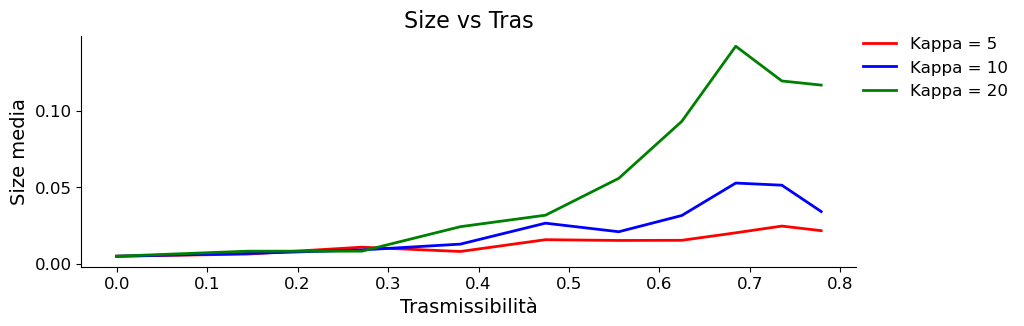

In [ ]:
# plot S,I,R vs time
fig, ax = plt.subplots(1, 1, figsize=(10,3))


#Plotto l'andamento    
ax.plot(
    tras, valmedi[0],
    # style keywords
    color = "red", lw = 2, 
    label = "Kappa = 5"
)

ax.plot(
    tras, valmedi[1],
    # style keywords
    color = "blue", lw = 2, 
    label = "Kappa = 10"
)

ax.plot(
    tras, valmedi[2],
    # style keywords
    color = "green", lw = 2, 
    label = "Kappa = 20"
)

ax.legend(loc=(1, 0.7), frameon=False)

ax.set_ylabel(r"Size media")
ax.set_xlabel(r"Trasmissibilità")
ax.set_title(f"Size vs Tras")

### Exercise 5.15
Approximately find the critical transmissibility $T_c$ for different values of $\kappa$ in your simulations, and compare your results to those of the manuscript. Are they similar? Since we are simulating a smaller system, we do not expect a perfect match, but we do expect a similar qualitative behaviouor.

Come si può notare dal grafico riportato in precedenza le varie trasmissibilità critiche sono circa le seguenti:
$$
\kappa = 20: T_c = 0.2
$$
$$
\kappa = 10: T_c = 0.4
$$
$$
\kappa = 5:  T_c = 0.6
$$
I valori non risultano essere in perfetto accordo con il modello simulato nel manoscritto, tuttavia è lo stesso evidente il fatto che andando da sinistra a destra nel plot si incontrano prima l'andamento con kappa uguale a 20, in un secondo momento quello con kappa uguale a 10 ed infine quello con kappa uguale a 5 (stessa situazione presente nel manoscritto). Dei tre valori di $T_c$ risulta essere maggiormente in disaccordo con il modello simulato quello con $\kappa$ uguale a 10.

### Exercise 5.16
Explain why $T_c$ decreases when $\kappa$ is increased. How is this related to the presence of super-spreaders, and how do they impact the global epidemic dynamics?

Notiamo che la trasmissibilità critica $T_c$ decresce all'aumentare del parametro $\kappa$. Tale parametro determina una variazione della "degree distribution", ossia la distribuzione del numero di connessioni che un singolo nodo ha ad altri nodi. In particolare la probabilità che un nodo abbia k legami con altri nodi costituenti il network è nulla se k è nullo (ossia ogni nodo deve avere almeno una connessione) ed invece decresce come un'esponenziale nel momento in cui ho che k è discosto da zero. Per $k \neq 0$ la probabilità di avere k connessioni risulta:
$$
p_k = Ck^{-\alpha}e^{-k/\kappa}
$$
Osservando tale espressione risulta evidente che all'aumentare di $\kappa$ a parità di "node degree" k la probabilità aumenterà di conseguenza. In una situazione del genere sarà più probabile avere dei super-spreaders, ossia dei nodi che presentano un numero molto elevato di collegamenti con altri nodi del network. Nel caso tale super-spreader dovesse essere infetto il fatto che presenta molti edges fa sì che possa infettare una porzione non trascurabile del network. Ciò si traduce in una size maggiore dell'outbreak.